<a href="https://colab.research.google.com/github/FadhelAleid/Data-Science-Bootcamps-for-SDAIA-Academy/blob/main/Final_Code_Stocks_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The scope of this exercise is to look to the financial and trade data that could impact the valuation of stocks in Saudi Market. 
THe used data has been collected from yahoo finance which covred the following:

*   200 Companies
*   Last 4 years data
*   Balancehseet 
*   Cashflow data
*   Day trade data



###Importing the Libraries and connect Colab to google drive

In [ ]:
#Import the required librabries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from google.colab import drive

#Mount to the drive
drive.mount('/content/gdrive')
sns.set(rc = {'figure.figsize':(15,5)})

Mounted at /content/gdrive


### Importing the data

In [ ]:
#Import the data from google drive and save to dataframes
trade_raw_df=pd.read_csv('/content/gdrive/My Drive/SDAIA Course/Copy of day.csv')
bs_raw_df=pd.read_csv('/content/gdrive/My Drive/SDAIA Course/Copy of bs.csv')
cf_raw_df=pd.read_csv('/content/gdrive/My Drive/SDAIA Course/Copy of cf.csv')

<Figure size 432x288 with 0 Axes>

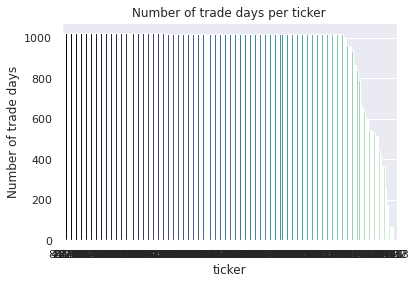

<Figure size 432x288 with 0 Axes>

In [ ]:
#Count of records raw data for day trade data
trd_plt= sns.countplot(x="ticker", data=trade_raw_df,order = trade_raw_df['ticker'].value_counts().index, palette="mako")
trd_plt.set_ylabel("Number of trade days")
trd_plt.set_title('Number of trade days per ticker')
plt.figure()


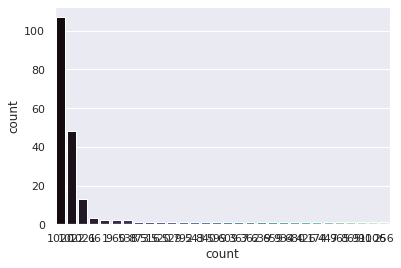

In [ ]:
#Explore the distribution of the number of records for the companies 
a= trade_raw_df.groupby('ticker')[['ticker']].size().reset_index().rename(columns ={0 :'count'})
bs_plt= sns.countplot(x="count", data=a,order = a['count'].value_counts().index, palette="mako")


Text(0.5, 1.0, 'Number of Balance sheets per ticker')

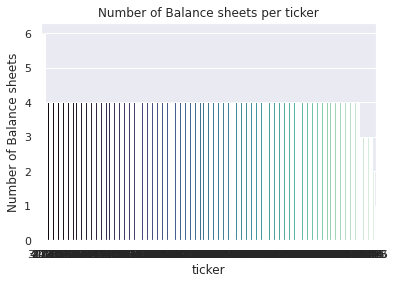

In [ ]:
#Count of records raw data for balancesheet
bs_plt= sns.countplot(x="ticker", data=bs_raw_df,order = bs_raw_df['ticker'].value_counts().index, palette="mako")
bs_plt.set_ylabel("Number of Balance sheets")
bs_plt.set_title('Number of Balance sheets per ticker')


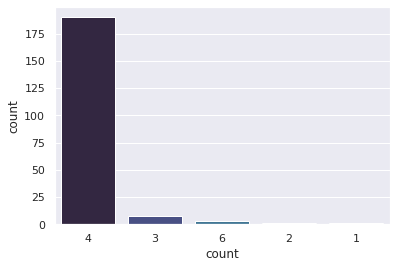

In [ ]:
#Explore the distribution of the number of records for the companies 
a= bs_raw_df.groupby('ticker')[['ticker']].size().reset_index().rename(columns ={0 :'count'})
bs_plt= sns.countplot(x="count", data=a,order = a['count'].value_counts().index, palette="mako")

Text(0.5, 1.0, 'Number of Cashflow Statments per ticker')

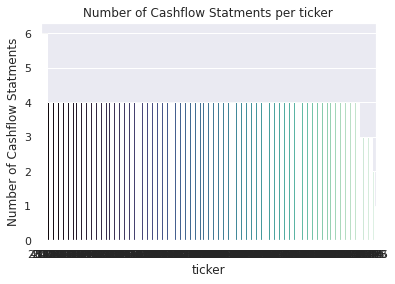

In [ ]:
#Count of records raw data for cashflow
cf_plt= sns.countplot(x="ticker", data=cf_raw_df,order = cf_raw_df['ticker'].value_counts().index, palette="mako")
cf_plt.set_ylabel("Number of Cashflow Statments")
cf_plt.set_title('Number of Cashflow Statments per ticker')

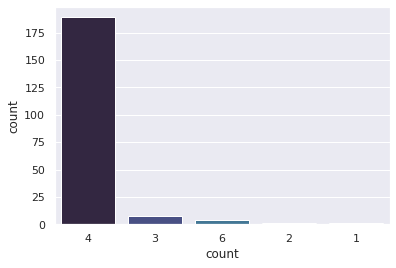

In [ ]:
#Explore the distribution of the number of records for the companies 
a= cf_raw_df.groupby('ticker')[['ticker']].size().reset_index().rename(columns ={0 :'count'})
bs_plt= sns.countplot(x="count", data=a,order = a['count'].value_counts().index, palette="mako")

### Clean day trade data

In [ ]:

#Remove the data for the companies that have trade data less than 1000 days
temp = pd.DataFrame(trade_raw_df.groupby('ticker')[['ticker']].size().reset_index().rename(columns ={0 :'count'}))
ticker_1000 = temp[temp['count'] >= 1000].ticker.unique()
trade_df=trade_raw_df[trade_raw_df.ticker.isin(ticker_1000)]


#Remove the data for the companies that do not have balancesheet data for 4 years
temp = pd.DataFrame(bs_raw_df.groupby('ticker')[['ticker']].size().reset_index().rename(columns ={0 :'count'}))
ticker_4 = temp[temp['count'] == 4].ticker.unique()
bs_df=bs_raw_df[bs_raw_df.ticker.isin(ticker_4)]


#Remove the data for the companies that do not have cashflow data for 4 years
temp = pd.DataFrame(cf_raw_df.groupby('ticker')[['ticker']].size().reset_index().rename(columns ={0 :'count'}))
ticker_4 = temp[temp['count'] == 4].ticker.unique()
cf_df=cf_raw_df[cf_raw_df.ticker.isin(ticker_4)]


#checking the data
trade_df.info()
trade_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172475 entries, 0 to 188597
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    172475 non-null  int64  
 1   Date          172475 non-null  object 
 2   Open          172475 non-null  float64
 3   High          172475 non-null  float64
 4   Low           172475 non-null  float64
 5   Close         172475 non-null  float64
 6   Volume        172475 non-null  float64
 7   Dividends     172475 non-null  float64
 8   Stock Splits  172475 non-null  float64
 9   ticker        172475 non-null  int64  
 10  Adj Close     0 non-null       float64
dtypes: float64(8), int64(2), object(1)
memory usage: 15.8+ MB


,Unnamed: 0,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Adj Close
0,0,2018-01-01,28.611736,28.611736,28.289739,28.473738,108316.0,0.0,0.0,2030,NaN
1,1,2018-01-02,28.565737,28.611738,28.151742,28.335739,117239.0,0.0,0.0,2030,NaN
2,2,2018-01-03,28.427737,28.473738,28.243740,28.473738,56235.0,0.0,0.0,2030,NaN
3,3,2018-01-04,28.427738,28.565736,28.381739,28.381739,97676.0,0.0,0.0,2030,NaN
4,4,2018-01-07,28.519739,28.887735,28.519739,28.611738,100046.0,0.0,0.0,2030,NaN


In [ ]:
#lower case all columns
trade_df.columns= trade_df.columns.str.lower().str.replace(' ', '_')

#Convert to the acurate format
trade_df["ticker"]= trade_df["ticker"].apply(str)
trade_df['date']=pd.to_datetime(trade_df['date'], errors='coerce')

#Drop un wanted columns
trade_df=trade_df.drop(["unnamed:_0","dividends","adj_close"],axis=1)

#Creat new id to merge with other data
trade_df["id"]=trade_df['date'].dt.year.astype(str)+"-"+trade_df["ticker"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Calculating the moving average to have more stable valuation by the model
trade_df['moving_5'] = trade_df.groupby('ticker')['close'].transform(lambda x: x.rolling(5, 1).mean())
trade_df['moving_10'] = trade_df.groupby('ticker')['close'].transform(lambda x: x.rolling(10, 1).mean())
trade_df['moving_100'] = trade_df.groupby('ticker')['close'].transform(lambda x: x.rolling(100, 1).mean())
trade_df['moving_200'] = trade_df.groupby('ticker')['close'].transform(lambda x: x.rolling(200, 1).mean())

In [ ]:
#re-checking the data
trade_df.info()
trade_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 172475 entries, 0 to 188597
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          172475 non-null  datetime64[ns]
 1   open          172475 non-null  float64       
 2   high          172475 non-null  float64       
 3   low           172475 non-null  float64       
 4   close         172475 non-null  float64       
 5   volume        172475 non-null  float64       
 6   stock_splits  172475 non-null  float64       
 7   ticker        172475 non-null  object        
 8   id            172475 non-null  object        
 9   moving_5      172475 non-null  float64       
 10  moving_10     172475 non-null  float64       
 11  moving_100    172475 non-null  float64       
 12  moving_200    172475 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 18.4+ MB


,date,open,high,low,close,volume,stock_splits,ticker,id,moving_5,moving_10,moving_100,moving_200
0,2018-01-01,28.611736,28.611736,28.289739,28.473738,108316.0,0.0,2030,2018-2030,28.473738,28.473738,28.473738,28.473738
1,2018-01-02,28.565737,28.611738,28.151742,28.335739,117239.0,0.0,2030,2018-2030,28.404738,28.404738,28.404738,28.404738
2,2018-01-03,28.427737,28.473738,28.243740,28.473738,56235.0,0.0,2030,2018-2030,28.427738,28.427738,28.427738,28.427738
3,2018-01-04,28.427738,28.565736,28.381739,28.381739,97676.0,0.0,2030,2018-2030,28.416238,28.416238,28.416238,28.416238
4,2018-01-07,28.519739,28.887735,28.519739,28.611738,100046.0,0.0,2030,2018-2030,28.455338,28.455338,28.455338,28.455338


### Cleaning Balance sheet data

In [ ]:
#checking the data
bs_df.info()
bs_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 0 to 804
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        760 non-null    int64  
 1   Unnamed: 1                        760 non-null    object 
 2   Total Liab                        759 non-null    float64
 3   Total Stockholder Equity          759 non-null    float64
 4   Other Current Liab                750 non-null    float64
 5   Total Assets                      759 non-null    float64
 6   Common Stock                      759 non-null    float64
 7   Other Current Assets              724 non-null    float64
 8   Retained Earnings                 739 non-null    float64
 9   Other Liab                        742 non-null    float64
 10  Treasury Stock                    525 non-null    float64
 11  Cash                              759 non-null    float64
 12  Total Cu

,Unnamed: 0,Unnamed: 1,Total Liab,Total Stockholder Equity,Other Current Liab,Total Assets,Common Stock,Other Current Assets,Retained Earnings,Other Liab,Treasury Stock,Cash,Total Current Liabilities,Other Stockholder Equity,Property Plant Equipment,Total Current Assets,Long Term Investments,Net Tangible Assets,Net Receivables,ticker,date,Intangible Assets,Capital Surplus,Minority Interest,Good Will,Other Assets,Deferred Long Term Asset Charges,Short Long Term Debt,Short Term Investments,Long Term Debt,Inventory,Accounts Payable,Deferred Long Term Liab,index
0,0,2020-12-31,1.027033e+07,5.083243e+08,9.294219e+06,5.185946e+08,1.500000e+08,1.805990e+05,5.641793e+07,6.122590e+05,3.019063e+08,3.065733e+07,9.658074e+06,3.019063e+08,5.720300e+04,3.924472e+07,4.792927e+08,5.083243e+08,8.373052e+06,2030,2020-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-12-31,1.105980e+07,4.539620e+08,1.022781e+07,4.650218e+08,1.500000e+08,2.107630e+05,5.802959e+07,5.415460e+05,2.459324e+08,3.631014e+07,1.051825e+07,2.459324e+08,5.931000e+04,4.870345e+07,4.162590e+08,4.539620e+08,1.217167e+07,2030,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2018-12-31,1.049018e+07,4.305261e+08,9.743259e+06,4.410162e+08,1.500000e+08,4.987850e+05,5.233110e+07,3.772800e+05,2.281950e+08,2.864327e+07,1.011290e+07,2.281950e+08,1.110100e+04,4.162524e+07,3.993799e+08,4.305261e+08,1.247317e+07,2030,2018-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2017-12-31,1.349543e+07,3.672804e+08,1.292028e+07,3.807758e+08,1.500000e+08,4.423790e+05,4.525492e+07,3.138090e+05,1.720255e+08,2.757014e+07,1.318162e+07,1.720255e+08,9.048000e+03,3.644512e+07,3.443217e+08,3.672804e+08,8.373052e+06,2030,2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2020-12-31,8.131670e+11,9.908480e+11,4.205900e+10,1.914261e+12,6.000000e+10,4.273000e+09,9.012730e+11,1.330360e+11,2.594000e+09,2.072320e+11,2.432110e+11,5.858000e+09,1.209460e+12,3.988790e+11,8.883700e+10,8.263010e+11,1.241940e+11,2222,2020-12-31 00:00:00,6.434300e+10,2.698100e+10,1.102460e+11,1.002040e+11,5.253800e+10,1.528000e+10,2.906400e+10,6.801000e+09,3.933530e+11,5.199900e+10,4.613500e+10,NaN,NaN


In [ ]:
#lower case all columns
bs_df.columns= bs_df.columns.str.lower().str.replace(' ', '_')

#Convert to the acurate format
bs_df["ticker"]= bs_df["ticker"].apply(str)
bs_df['date']=pd.to_datetime(bs_df['date'], errors='coerce')

#Remove rows with no data
bs_df= bs_df[bs_df['index'].isnull()]

#Creat new id to merge with other data
bs_df["id"]=(bs_df['date'].dt.year-1).astype(str)+"-"+bs_df["ticker"]


#Drop un wanted columns
bs_df=bs_df.drop(["unnamed:_0","unnamed:_1","index","treasury_stock","date"],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#re-checking the data
bs_df.info()
bs_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 0 to 804
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   total_liab                        759 non-null    float64
 1   total_stockholder_equity          759 non-null    float64
 2   other_current_liab                750 non-null    float64
 3   total_assets                      759 non-null    float64
 4   common_stock                      759 non-null    float64
 5   other_current_assets              724 non-null    float64
 6   retained_earnings                 739 non-null    float64
 7   other_liab                        742 non-null    float64
 8   cash                              759 non-null    float64
 9   total_current_liabilities         758 non-null    float64
 10  other_stockholder_equity          524 non-null    float64
 11  property_plant_equipment          758 non-null    float64
 12  total_cu

,total_liab,total_stockholder_equity,other_current_liab,total_assets,common_stock,other_current_assets,retained_earnings,other_liab,cash,total_current_liabilities,other_stockholder_equity,property_plant_equipment,total_current_assets,long_term_investments,net_tangible_assets,net_receivables,ticker,intangible_assets,capital_surplus,minority_interest,good_will,other_assets,deferred_long_term_asset_charges,short_long_term_debt,short_term_investments,long_term_debt,inventory,accounts_payable,deferred_long_term_liab,id
0,1.027033e+07,5.083243e+08,9.294219e+06,5.185946e+08,1.500000e+08,1.805990e+05,5.641793e+07,6.122590e+05,3.065733e+07,9.658074e+06,3.019063e+08,5.720300e+04,3.924472e+07,4.792927e+08,5.083243e+08,8.373052e+06,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-2030
1,1.105980e+07,4.539620e+08,1.022781e+07,4.650218e+08,1.500000e+08,2.107630e+05,5.802959e+07,5.415460e+05,3.631014e+07,1.051825e+07,2.459324e+08,5.931000e+04,4.870345e+07,4.162590e+08,4.539620e+08,1.217167e+07,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-2030
2,1.049018e+07,4.305261e+08,9.743259e+06,4.410162e+08,1.500000e+08,4.987850e+05,5.233110e+07,3.772800e+05,2.864327e+07,1.011290e+07,2.281950e+08,1.110100e+04,4.162524e+07,3.993799e+08,4.305261e+08,1.247317e+07,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-2030
3,1.349543e+07,3.672804e+08,1.292028e+07,3.807758e+08,1.500000e+08,4.423790e+05,4.525492e+07,3.138090e+05,2.757014e+07,1.318162e+07,1.720255e+08,9.048000e+03,3.644512e+07,3.443217e+08,3.672804e+08,8.373052e+06,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-2030
4,8.131670e+11,9.908480e+11,4.205900e+10,1.914261e+12,6.000000e+10,4.273000e+09,9.012730e+11,1.330360e+11,2.072320e+11,2.432110e+11,5.858000e+09,1.209460e+12,3.988790e+11,8.883700e+10,8.263010e+11,1.241940e+11,2222,6.434300e+10,2.698100e+10,1.102460e+11,1.002040e+11,5.253800e+10,1.528000e+10,2.906400e+10,6.801000e+09,3.933530e+11,5.199900e+10,4.613500e+10,NaN,2019-2222


### Clean Cash flow data

In [ ]:
#checking the data
cf_df.info()
cf_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 0 to 806
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unnamed: 0                                 756 non-null    int64  
 1   Unnamed: 1                                 756 non-null    object 
 2   Investments                                513 non-null    float64
 3   Change To Liabilities                      756 non-null    float64
 4   Total Cashflows From Investing Activities  755 non-null    float64
 5   Total Cash From Financing Activities       716 non-null    float64
 6   Change To Operating Activities             681 non-null    float64
 7   Net Income                                 756 non-null    float64
 8   Change In Cash                             756 non-null    float64
 9   Total Cash From Operating Activities       756 non-null    float64
 10  Depreciation              

,Unnamed: 0,Unnamed: 1,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Total Cash From Financing Activities,Change To Operating Activities,Net Income,Change In Cash,Total Cash From Operating Activities,Depreciation,Dividends Paid,Change To Netincome,Capital Expenditures,Change To Account Receivables,ticker,date,Net Borrowings,Other Cashflows From Investing Activities,Change To Inventory,Other Cashflows From Financing Activities,Repurchase Of Stock,Effect Of Exchange Rate,Issuance Of Stock,index
0,0,2020-12-31,-6.009969e+06,0.000000e+00,-6.021156e+06,-1.500000e+07,3.754982e+06,1.338026e+07,-5.652807e+06,1.536835e+07,1.329400e+04,-1.500000e+07,-1.780190e+06,-1.118700e+04,NaN,2030,2020-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-12-31,-1.087824e+06,0.000000e+00,-1.139508e+06,-1.125000e+07,6.578320e+05,1.717070e+07,7.666869e+06,2.005638e+07,5.525000e+03,-1.125000e+07,2.222321e+06,-5.373400e+04,NaN,2030,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2018-12-31,-1.087824e+06,0.000000e+00,-5.950000e+03,-7.500000e+06,-2.721093e+06,1.455625e+07,1.073126e+06,8.579076e+06,3.897000e+03,-7.500000e+06,5.455260e+05,-5.950000e+03,-3.805503e+06,2030,2018-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2017-12-31,-1.087824e+06,0.000000e+00,-2.629000e+03,-7.500000e+06,-3.621111e+06,7.317568e+06,4.322678e+06,4.325307e+06,4.132000e+03,-7.500000e+06,6.247180e+05,-2.629000e+03,-3.805503e+06,2030,2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2020-12-31,4.853600e+10,-1.625000e+10,-2.089900e+10,-2.348720e+11,-8.496000e+09,1.849260e+11,2.952600e+10,2.852970e+11,7.446900e+10,-2.611840e+11,2.103530e+11,-1.010300e+11,2.217200e+10,2222,2020-12-31 00:00:00,3.452700e+10,4.080000e+09,1.589000e+10,-8.215000e+09,NaN,NaN,NaN,NaN


In [ ]:
#lower case all columns
cf_df.columns= cf_df.columns.str.lower().str.replace(' ', '_')

#Convert to the acurate format
cf_df["ticker"]= cf_df["ticker"].apply(str)
cf_df['date']=pd.to_datetime(cf_df['date'], errors='coerce')

#Remove rows with no data
cf_df= cf_df[cf_df['index'].isnull()]

#Creat new id to merge with other data
cf_df["id"]=(cf_df['date'].dt.year-1).astype(str)+"-"+cf_df["ticker"]

#Drop un wanted columns
cf_df=cf_df.drop(["unnamed:_0","unnamed:_1","index","date"],axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#re-checking the data
cf_df.info()
cf_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 0 to 806
Data columns (total 22 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   investments                                513 non-null    float64
 1   change_to_liabilities                      756 non-null    float64
 2   total_cashflows_from_investing_activities  755 non-null    float64
 3   total_cash_from_financing_activities       716 non-null    float64
 4   change_to_operating_activities             681 non-null    float64
 5   net_income                                 756 non-null    float64
 6   change_in_cash                             756 non-null    float64
 7   total_cash_from_operating_activities       756 non-null    float64
 8   depreciation                               756 non-null    float64
 9   dividends_paid                             455 non-null    float64
 10  change_to_netincome       

,investments,change_to_liabilities,total_cashflows_from_investing_activities,total_cash_from_financing_activities,change_to_operating_activities,net_income,change_in_cash,total_cash_from_operating_activities,depreciation,dividends_paid,change_to_netincome,capital_expenditures,change_to_account_receivables,ticker,net_borrowings,other_cashflows_from_investing_activities,change_to_inventory,other_cashflows_from_financing_activities,repurchase_of_stock,effect_of_exchange_rate,issuance_of_stock,id
0,-6.009969e+06,0.000000e+00,-6.021156e+06,-1.500000e+07,3.754982e+06,1.338026e+07,-5.652807e+06,1.536835e+07,1.329400e+04,-1.500000e+07,-1.780190e+06,-1.118700e+04,NaN,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-2030
1,-1.087824e+06,0.000000e+00,-1.139508e+06,-1.125000e+07,6.578320e+05,1.717070e+07,7.666869e+06,2.005638e+07,5.525000e+03,-1.125000e+07,2.222321e+06,-5.373400e+04,NaN,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-2030
2,-1.087824e+06,0.000000e+00,-5.950000e+03,-7.500000e+06,-2.721093e+06,1.455625e+07,1.073126e+06,8.579076e+06,3.897000e+03,-7.500000e+06,5.455260e+05,-5.950000e+03,-3.805503e+06,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-2030
3,-1.087824e+06,0.000000e+00,-2.629000e+03,-7.500000e+06,-3.621111e+06,7.317568e+06,4.322678e+06,4.325307e+06,4.132000e+03,-7.500000e+06,6.247180e+05,-2.629000e+03,-3.805503e+06,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-2030
4,4.853600e+10,-1.625000e+10,-2.089900e+10,-2.348720e+11,-8.496000e+09,1.849260e+11,2.952600e+10,2.852970e+11,7.446900e+10,-2.611840e+11,2.103530e+11,-1.010300e+11,2.217200e+10,2222,3.452700e+10,4.080000e+09,1.589000e+10,-8.215000e+09,NaN,NaN,NaN,2019-2222


### Merging the data

In [ ]:
#merging the data to from al sources to one data frame
merged_df = pd.merge(trade_df, bs_df,how="left", on=["id"])
merged_df = pd.merge(merged_df, cf_df,how="left", on=["id"])

In [ ]:
#re-checking the data
merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174555 entries, 0 to 174554
Data columns (total 63 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   date                                       174555 non-null  datetime64[ns]
 1   open                                       174555 non-null  float64       
 2   high                                       174555 non-null  float64       
 3   low                                        174555 non-null  float64       
 4   close                                      174555 non-null  float64       
 5   volume                                     174555 non-null  float64       
 6   stock_splits                               174555 non-null  float64       
 7   ticker_x                                   174555 non-null  object        
 8   id                                         174555 non-null  object        
 9   movi

,date,open,high,low,close,volume,stock_splits,ticker_x,id,moving_5,moving_10,moving_100,moving_200,total_liab,total_stockholder_equity,other_current_liab,total_assets,common_stock,other_current_assets,retained_earnings,other_liab,cash,total_current_liabilities,other_stockholder_equity,property_plant_equipment,total_current_assets,long_term_investments,net_tangible_assets,net_receivables,ticker_y,intangible_assets,capital_surplus,minority_interest,good_will,other_assets,deferred_long_term_asset_charges,short_long_term_debt,short_term_investments,long_term_debt,inventory,accounts_payable,deferred_long_term_liab,investments,change_to_liabilities,total_cashflows_from_investing_activities,total_cash_from_financing_activities,change_to_operating_activities,net_income,change_in_cash,total_cash_from_operating_activities,depreciation,dividends_paid,change_to_netincome,capital_expenditures,change_to_account_receivables,ticker,net_borrowings,other_cashflows_from_investing_activities,change_to_inventory,other_cashflows_from_financing_activities,repurchase_of_stock,effect_of_exchange_rate,issuance_of_stock
0,2018-01-01,28.611736,28.611736,28.289739,28.473738,108316.0,0.0,2030,2018-2030,28.473738,28.473738,28.473738,28.473738,11059798.0,453961971.0,10227812.0,465021769.0,150000000.0,210763.0,58029588.0,541546.0,36310138.0,10518252.0,245932383.0,59310.0,48703453.0,416259006.0,453961971.0,12171672.0,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1087824.0,0.0,-1139508.0,-11250000.0,657832.0,17170699.0,7666869.0,20056377.0,5525.0,-11250000.0,2222321.0,-53734.0,NaN,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,28.565737,28.611738,28.151742,28.335739,117239.0,0.0,2030,2018-2030,28.404738,28.404738,28.404738,28.404738,11059798.0,453961971.0,10227812.0,465021769.0,150000000.0,210763.0,58029588.0,541546.0,36310138.0,10518252.0,245932383.0,59310.0,48703453.0,416259006.0,453961971.0,12171672.0,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1087824.0,0.0,-1139508.0,-11250000.0,657832.0,17170699.0,7666869.0,20056377.0,5525.0,-11250000.0,2222321.0,-53734.0,NaN,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,28.427737,28.473738,28.243740,28.473738,56235.0,0.0,2030,2018-2030,28.427738,28.427738,28.427738,28.427738,11059798.0,453961971.0,10227812.0,465021769.0,150000000.0,210763.0,58029588.0,541546.0,36310138.0,10518252.0,245932383.0,59310.0,48703453.0,416259006.0,453961971.0,12171672.0,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1087824.0,0.0,-1139508.0,-11250000.0,657832.0,17170699.0,7666869.0,20056377.0,5525.0,-11250000.0,2222321.0,-53734.0,NaN,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,28.427738,28.565736,28.381739,28.381739,97676.0,0.0,2030,2018-2030,28.416238,28.416238,28.416238,28.416238,11059798.0,453961971.0,10227812.0,465021769.0,150000000.0,210763.0,58029588.0,541546.0,36310138.0,10518252.0,245932383.0,59310.0,48703453.0,416259006.0,453961971.0,12171672.0,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1087824.0,0.0,-1139508.0,-11250000.0,657832.0,17170699.0,7666869.0,20056377.0,5525.0,-11250000.0,2222321.0,-53734.0,NaN,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-07,28.519739,28.887735,28.519739,28.611738,100046.0,0.0,2030,2018-2030,28.455338,28.455338,28.455338,28.455338,11059798.0,453961971.0,10227812.0,465021769.0,150000000.0,210763.0,58029588.0,541546.0,36310138.0,10518252.0,245932383.0,59310.0,48703453.0,416259006.0,453961971.0,12171672.0,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1087824.0,0.0,-1139508.0,-11250000.0,657832.0,17170699.0,7666869.0,20056377.0,5525.0,-11250000.0,2222321.0,-53734.0,NaN,2030,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Remove rows with no data
merged_df= merged_df[merged_df['total_assets'].notnull()]

#Drop un wanted columns
merged_df=merged_df.drop(["id","ticker_y"],axis=1)

#merged_df["company_value"]=merged_df["common_stock"]*merged_df["close"]

#fill na by zero
merged_df=merged_df.fillna(0)


In [ ]:
#re-checking the data
merged_df.info()
merged_df.head()
merged_df.groupby("ticker_x").count()["date"].sort_values(ascending = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86330 entries, 0 to 174053
Data columns (total 61 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   date                                       86330 non-null  datetime64[ns]
 1   open                                       86330 non-null  float64       
 2   high                                       86330 non-null  float64       
 3   low                                        86330 non-null  float64       
 4   close                                      86330 non-null  float64       
 5   volume                                     86330 non-null  float64       
 6   stock_splits                               86330 non-null  float64       
 7   ticker_x                                   86330 non-null  object        
 8   moving_5                                   86330 non-null  float64       
 9   moving_10       

ticker_x
4100    1820
7040     772
1304     770
4240     770
2270     770
        ... 
4250     520
4260     520
4270     520
1010     520
8290     260
Name: date, Length: 162, dtype: int64

In [ ]:
merged_df.describe()

,open,high,low,close,volume,stock_splits,moving_5,moving_10,moving_100,moving_200,total_liab,total_stockholder_equity,other_current_liab,total_assets,common_stock,other_current_assets,retained_earnings,other_liab,cash,total_current_liabilities,other_stockholder_equity,property_plant_equipment,total_current_assets,long_term_investments,net_tangible_assets,net_receivables,intangible_assets,capital_surplus,minority_interest,good_will,other_assets,deferred_long_term_asset_charges,short_long_term_debt,short_term_investments,long_term_debt,inventory,accounts_payable,deferred_long_term_liab,investments,change_to_liabilities,total_cashflows_from_investing_activities,total_cash_from_financing_activities,change_to_operating_activities,net_income,change_in_cash,total_cash_from_operating_activities,depreciation,dividends_paid,change_to_netincome,capital_expenditures,change_to_account_receivables,net_borrowings,other_cashflows_from_investing_activities,change_to_inventory,other_cashflows_from_financing_activities,repurchase_of_stock,effect_of_exchange_rate,issuance_of_stock
count,86330.000000,86330.000000,86330.000000,86330.000000,8.633000e+04,86330.000000,86330.000000,86330.000000,86330.000000,86330.000000,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04,8.633000e+04
mean,28.038952,28.332329,27.775647,28.045193,7.828117e+05,0.000465,28.035909,28.026213,28.039937,28.055845,1.909560e+10,7.055997e+09,6.265183e+08,2.650707e+10,3.326302e+09,9.841706e+08,2.986658e+09,1.236827e+09,1.392040e+09,1.521326e+10,5.520704e+08,6.664843e+09,5.128596e+09,3.952966e+09,6.515337e+09,1.208452e+09,3.007020e+08,2.152399e+08,3.554786e+08,2.448072e+08,1.021516e+10,1.337632e+07,4.150975e+08,3.526914e+08,2.349159e+09,4.963023e+08,1.285463e+10,6.204615e+06,-3.695868e+08,1.086555e+08,-7.756791e+08,3.329172e+08,-5.578839e+08,3.880237e+08,3.477386e+07,4.792756e+08,4.849533e+08,-3.591210e+08,1.973144e+08,-4.503710e+08,-1.086767e+08,-1.214617e+08,4.101870e+07,-5.682113e+06,7.804204e+08,-1.310789e+07,-3.581439e+06,8.109175e+07
std,22.947340,23.181080,22.724691,22.954853,3.069356e+06,0.025507,22.923621,22.886063,22.325100,21.718539,6.435968e+10,2.220224e+10,1.894472e+09,8.101837e+10,6.935167e+09,3.702269e+09,1.296293e+10,6.961234e+09,5.085340e+09,5.796254e+10,9.268238e+09,3.587970e+10,1.623680e+10,1.307580e+10,2.098510e+10,4.559368e+09,1.593142e+09,1.623308e+09,2.303120e+09,1.707000e+09,4.263884e+10,9.293850e+07,1.486013e+09,1.941942e+09,1.077319e+10,1.786629e+09,5.434221e+10,6.152111e+07,1.954357e+09,1.273799e+09,2.893568e+09,6.384893e+09,5.186582e+09,1.653921e+09,2.440426e+09,5.601904e+09,1.979553e+09,1.406185e+09,7.693801e+08,2.266503e+09,1.490393e+09,1.018766e+09,1.874246e+08,2.745841e+08,6.457206e+09,8.202890e+07,4.336388e+07,5.466267e+08
min,4.913211,4.913211,4.875590,4.883116,0.000000e+00,0.000000,5.734545,5.772727,6.287484,6.355582,2.185852e+06,1.578926e+07,0.000000e+00,3.996018e+07,1.500000e+07,0.000000e+00,-2.656727e+09,0.000000e+00,8.402800e+04,2.185852e+06,-8.657438e+09,8.000000e+03,2.113100e+05,0.000000e+00,-1.211308e+10,0.000000e+00,0.000000e+00,0.000000e+00,-9.997010e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.598156e+10,-3.950163e+09,-2.339920e+10,-2.304106e+10,-5.986212e+10,-4.132141e+09,-2.032737e+10,-4.757127e+10,0.000000e+00,-1.319013e+10,-9.582171e+08,-2.339922e+10,-2.322384e+10,-7.931536e+09,-2.839002e+08,-2.732963e+09,-1

###EDA

In [ ]:
#Find the correlation between the features and the closing price
merged_df.corrwith(merged_df["close"], axis = 0).sort_values(ascending = False)

close                                        1.000000
high                                         0.999832
low                                          0.999816
open                                         0.999678
moving_5                                     0.999464
moving_10                                    0.998633
moving_100                                   0.988236
moving_200                                   0.981374
retained_earnings                            0.297476
inventory                                    0.267254
net_income                                   0.237041
minority_interest                            0.231412
deferred_long_term_asset_charges             0.214933
cash                                         0.209063
total_current_assets                         0.196509
good_will                                    0.193932
total_stockholder_equity                     0.191819
other_current_liab                           0.191591
net_tangible_assets         

####Plotting the data

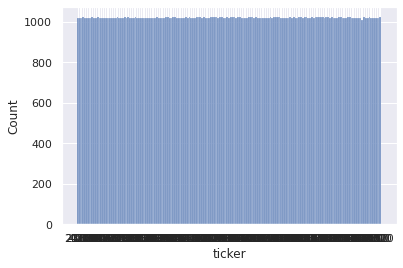

In [ ]:
#Check the frequcncy of the data in the data sets
sns.histplot(data=trade_df, x="ticker",palette="mako")

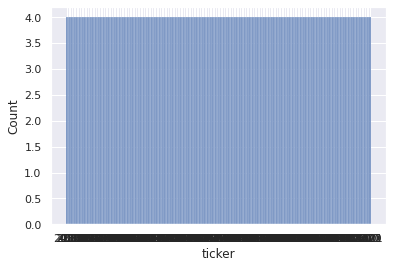

In [ ]:
bs_df.groupby("ticker").count()["id"].sort_values(ascending = False)
sns.histplot(data=bs_df, x="ticker",palette="mako")

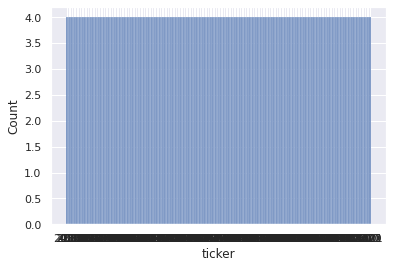

In [ ]:
cf_df.groupby("ticker").count()["id"].sort_values(ascending = False)
sns.histplot(data=bs_df, x="ticker",palette="mako")

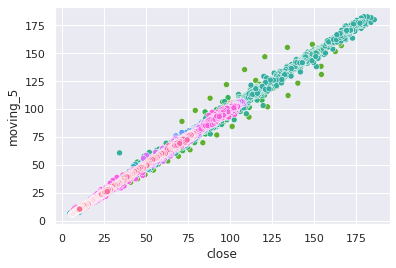

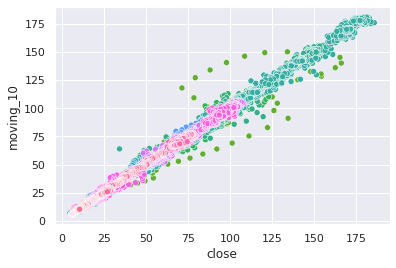

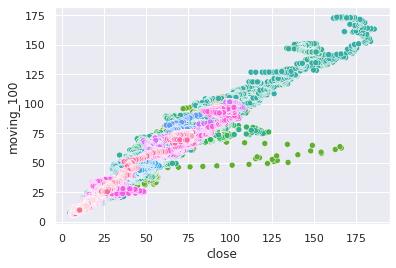

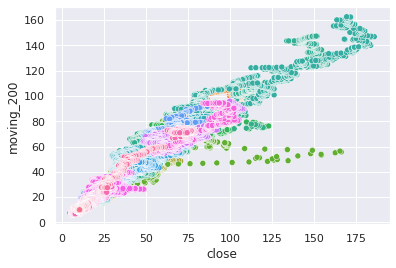

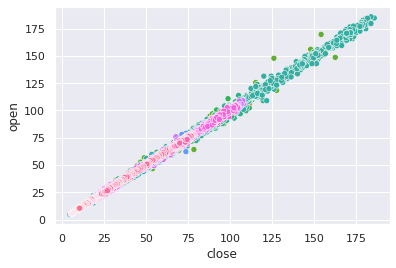

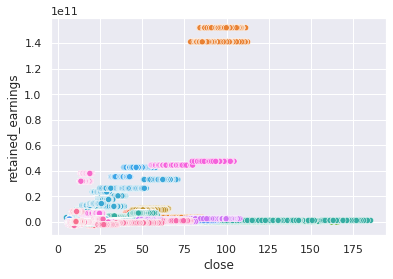

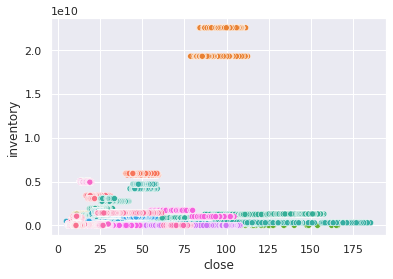

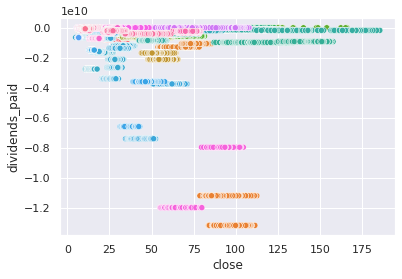

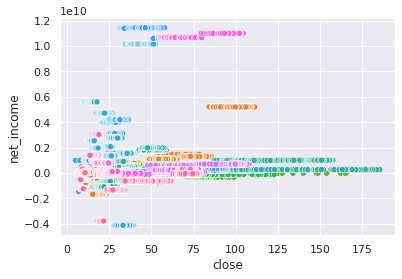

In [ ]:
for col in ["moving_5","moving_10","moving_100","moving_200","open","retained_earnings","inventory","dividends_paid","net_income"]:
  plt.figure()
  sns.scatterplot(data=merged_df, x="close", y=col ,hue="ticker_x",legend = False)

### Data Pre-Processing

In [ ]:
#Features selections

#including all features except the ones that ones that are not useful or available period the opening of the trade date
x=merged_df.drop(columns=["close","ticker","date","ticker_x","ticker","high","low","volume"])

#Including only highly correlated features with the close price 
#x=merged_df[["open","moving_5","moving_10","moving_100","moving_200","retained_earnings","inventory","net_income","minority_interest","deferred_long_term_asset_charges","cash","dividends_paid"]]

#Including only highly correlated financial features with the close price 
#x=merged_df[["retained_earnings","inventory","net_income","minority_interest","deferred_long_term_asset_charges","cash"]]

y= merged_df.close
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=42)

### Modeling

The Linear Regression Model Performance on Test set is 0.28  using MSE
The Linear Regression Model Performance on Test set is 1.00  using R Squared Error
The Linear Regression Model Performance on Test set is 0.96 % using MAPE


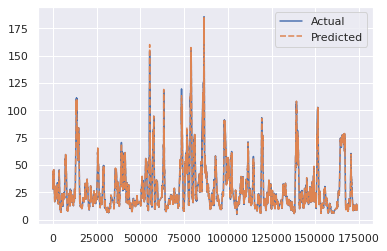

In [ ]:
#Check LinearRegression with unstandardized data

reg = LinearRegression()
reg.fit(x_train,y_train)
y_pred = reg.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

sns.lineplot(data=df)


# Model Acuracy
from sklearn import metrics
print("The Linear Regression Model Performance on Test set is {:.2f}  using MSE".format(metrics.mean_squared_error(y_test, y_pred)))
print("The Linear Regression Model Performance on Test set is {:.2f}  using R Squared Error".format(metrics.r2_score(y_test, y_pred)))
print("The Linear Regression Model Performance on Test set is {:.2f} % using MAPE".format(metrics.mean_absolute_percentage_error(y_test, y_pred)*100))


In [ ]:
#Standardizing the data
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in x_train.columns:
    if x_train.loc[:, col].dtype != 'O':
        scaler.fit(x_train.loc[:, col].values.reshape(-1, 1))
        x_train.loc[:, col] = scaler.transform(x_train.loc[:, col].values.reshape(-1, 1))
        x_test.loc[:, col] = scaler.transform(x_test.loc[:, col].values.reshape(-1, 1))

The Linear Regression Model Performance on Test set is 0.28  using MSE
The Linear Regression Model Performance on Test set is 1.00  using R Squared Error
The Linear Regression Model Performance on Test set is 0.96 % using MAPE


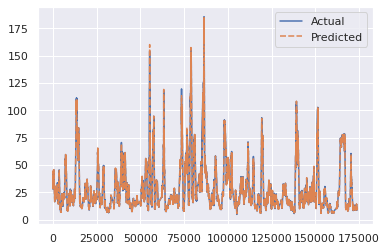

In [ ]:
#Check LinearRegression with standardized data
reg_model = LinearRegression()
reg_model.fit(x_train, y_train)
y_pred = reg_model.predict(x_test)
reg_y_ped=y_pred

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.lineplot(data=df)

# Model Acuracy
print("The Linear Regression Model Performance on Test set is {:.2f}  using MSE".format(metrics.mean_squared_error(y_test, y_pred)))
print("The Linear Regression Model Performance on Test set is {:.2f}  using R Squared Error".format(metrics.r2_score(y_test, y_pred)))
print("The Linear Regression Model Performance on Test set is {:.2f} % using MAPE".format(metrics.mean_absolute_percentage_error(y_test, y_pred)*100))

The Lasso Regression Model Performance on Test set is 1.31  using MSE
The Lasso Regression Model Performance on Test set is 1.00  using R Squared Error
The Lasso Regression Model Performance on Test set is 3.71 % using MAPE


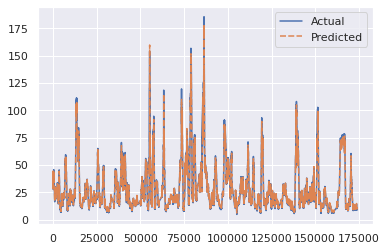

In [ ]:
#Check Lasso with standardized data
ls_model = Lasso()
ls_model.fit(x_train, y_train)
y_pred = ls_model.predict(x_test)
ls_y_ped=y_pred
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.lineplot(data=df)

# Model Acuracy
print("The Lasso Regression Model Performance on Test set is {:.2f}  using MSE".format(metrics.mean_squared_error(y_test, y_pred)))
print("The Lasso Regression Model Performance on Test set is {:.2f}  using R Squared Error".format(metrics.r2_score(y_test, y_pred)))
print("The Lasso Regression Model Performance on Test set is {:.2f} % using MAPE".format(metrics.mean_absolute_percentage_error(y_test, y_pred)*100))

The Ridge Regression Model Performance on Test set is 0.28  using MSE
The Ridge Regression Model Performance on Test set is 1.00  using R Squared Error
The Ridge Regression Model Performance on Test set is 0.96 % using MAPE


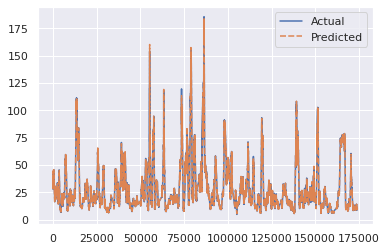

In [ ]:
#Check Ridge with standardized data
rdg_model = Ridge()
rdg_model.fit(x_train, y_train)
y_pred = rdg_model.predict(x_test)
rdg_y_ped=y_pred


df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.lineplot(data=df)

# Model Acuracy
print("The Ridge Regression Model Performance on Test set is {:.2f}  using MSE".format(metrics.mean_squared_error(y_test, y_pred)))
print("The Ridge Regression Model Performance on Test set is {:.2f}  using R Squared Error".format(metrics.r2_score(y_test, y_pred)))
print("The Ridge Regression Model Performance on Test set is {:.2f} % using MAPE".format(metrics.mean_absolute_percentage_error(y_test, y_pred)*100))

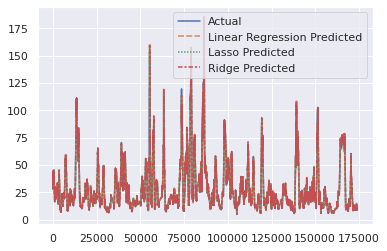

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Linear Regression Predicted': reg_y_ped, 'Lasso Predicted': ls_y_ped, 'Ridge Predicted': rdg_y_ped })
sns.lineplot(data=df)